In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(720, 960, 3)


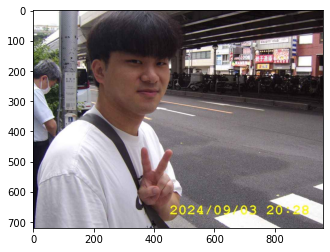

In [2]:
img_path = './images/image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
model_dir = './models'

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [4]:
segvalues, output = model.segmentAsPascalvoc(img_path)

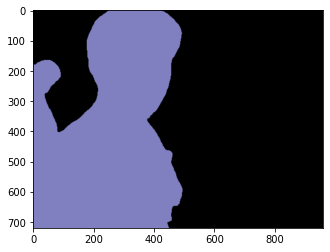

background
person


In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

plt.imshow(output)
plt.show()

segvalues

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [6]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [7]:
colormap[15]

array([192, 128, 128])

(720, 960)


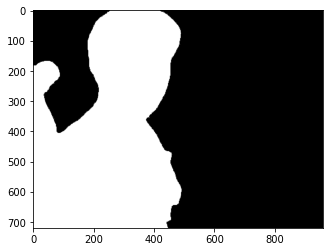

In [8]:
seg_color = (128,128,192)

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

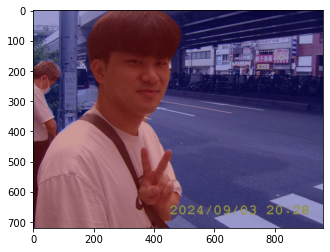

In [9]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

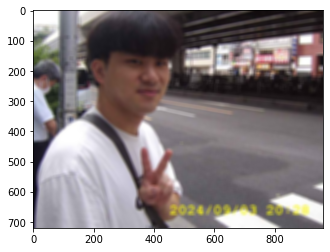

In [10]:
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

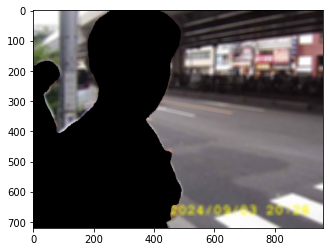

In [11]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

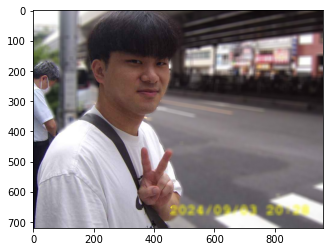

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
cv2.imwrite('./images/img_dof.png', img_concat)

True

여기까지가 노드 내용

![marked_image](./images/img_dof_marked.png)

### 문제점
- 왼쪽 아저씨도 같이 선명하게 나온다.
- 목과 눈같이 곡률이 큰 움푹 들어간 부분의 경계가 살짝 벗어나있다.

### watershed

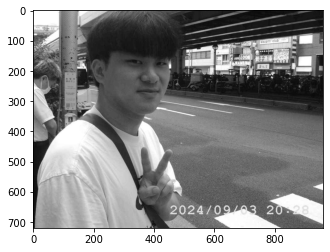

In [14]:
img_watershed = img_orig.copy()

#그레이스케일 변환
img_watershed_gray = cv2.cvtColor(img_watershed, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_watershed_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(img_watershed_gray, cmap='gray')
plt.show()

In [15]:
#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

#dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=3)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

In [16]:
#Background에서 Foregrand를 제외한 영역을 Unknow영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

#FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

In [17]:
#watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(img_watershed,markers)
img_watershed[markers == -1] = [255,0,0]

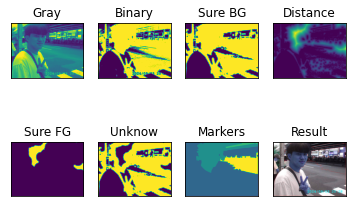

In [18]:
images = [img_watershed_gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, img_watershed]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()

watershed를 사용한 방법은 경계가 뚜렷하지 않고 얼굴과 손을 배경으로 같이 잡는 모습이 보인다.

### 이미지 컨투어

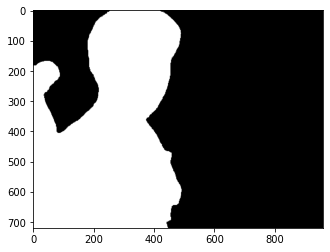

In [19]:
seg_map_binary = seg_map.astype(np.uint8)

#컨투어 찾기 
#cv2.RETR_EXTERNAL : 외곽선만 찾음
#cv2.CHAIN_APPROX_SIMPLE : 컨투어를 찾을 때 외곽선의 점을 단순화(같은 직선 상의 점들은 모두 버림), 계산 속도 증가 및 메모리 절약 
#cv2.CHAIN_APPROX_NONE : 점들을 전부 저장
#해당 함수는 2개의 값을 return하는데 아래와 같다. 
#contours: 각 컨투어의 좌표를 저장한 리스트.
#hierarchy : 계층구조 (도넛. 즉, 외곽선 안에 또다른 외곽선이 있을 때!) 여기서는 필요없음 
contours, _ = cv2.findContours(seg_map_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#새로운 seg_map 초기화 
filtered_seg_map = np.zeros_like(seg_map_binary) 

#영역 크기 기반 필터링 
min_area = 900  # 최소 면적(넓이) 필터링 기준
for contour in contours:
    area = cv2.contourArea(contour)  # 컨투어 면적 계산
    if area > min_area: 
        cv2.drawContours(filtered_seg_map, [contour], -1, 1, thickness=cv2.FILLED)

#조건 지정 후, 다시 논리형으로
seg_map = filtered_seg_map.astype(bool)

plt.imshow(seg_map, cmap='gray')
plt.show()

이미지 컨투어 함수

In [20]:
def imgContour(seg_map):
    seg_map_binary = seg_map.astype(np.uint8)

    #컨투어 찾기 
    #cv2.RETR_EXTERNAL : 외곽선만 찾음
    #cv2.CHAIN_APPROX_SIMPLE : 컨투어를 찾을 때 외곽선의 점을 단순화(같은 직선 상의 점들은 모두 버림), 계산 속도 증가 및 메모리 절약 
    #cv2.CHAIN_APPROX_NONE : 점들을 전부 저장
    #해당 함수는 2개의 값을 return하는데 아래와 같다. 
    #contours: 각 컨투어의 좌표를 저장한 리스트.
    #hierarchy : 계층구조 (도넛. 즉, 외곽선 안에 또다른 외곽선이 있을 때!) 여기서는 필요없음 
    contours, _ = cv2.findContours(seg_map_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #새로운 seg_map 초기화 
    filtered_seg_map = np.zeros_like(seg_map_binary) 

    #영역 크기 기반 필터링 
    min_area = 900  # 최소 면적(넓이) 필터링 기준
    for contour in contours:
        area = cv2.contourArea(contour)  # 컨투어 면적 계산
        if area > min_area: 
            cv2.drawContours(filtered_seg_map, [contour], -1, 1, thickness=cv2.FILLED)

    #조건 지정 후, 다시 논리형으로
    return filtered_seg_map.astype(bool)

### pixellib instance segmentation

In [21]:
from pixellib.instance import instance_segmentation
import time

inst_segment = instance_segmentation()
inst_segment.load_model('./models/mask_rcnn_coco.h5')

Instructions for updating:
Use fn_output_signature instead


/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Inference Time: 21.23seconds


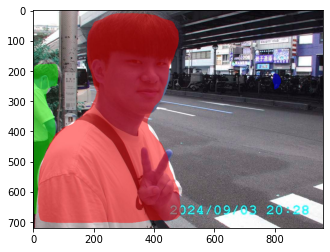

In [22]:
start = time.time()
seg_mask, img_inst = inst_segment.segmentImage(img_path)
end = time.time()
print(f"Inference Time: {end - start:.2f}seconds")

plt.imshow(img_inst)
plt.show()

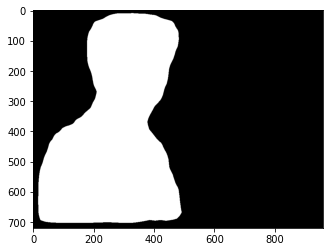

In [23]:
plt.imshow(seg_mask['masks'][:, :, 0], cmap='gray')
plt.show()

함수로 만들면

In [24]:
def instSeg(img_path, inst_segment):
    start = time.time()
    seg_mask, img_inst = inst_segment.segmentImage(img_path)#seg_mask는 딕셔너리, img_inst는 세그먼트별 색입힌 이미지
    end = time.time()
    t_time = end - start#turnaround time 소요시간
    
    return seg_mask, img_inst, t_time

In [29]:
def cutMask(img_orig, seg_map):
    img_mask = seg_map.astype(np.uint8) * 255
    img_orig_blur = cv2.blur(img_orig, (13,13))

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    return img_orig, img_mask, cv2.bitwise_and(img_orig_blur, img_bg_mask)

In [30]:
def mergeMask(img_orig, img_mask, img_bg_blur):
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    return np.where(img_mask_color==255, img_orig, img_bg_blur)

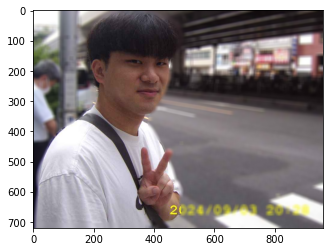

In [31]:
inst_seg_mask = seg_mask['masks'][:, :, 0]
img_inst_blur = mergeMask(*cutMask(img_orig, inst_seg_mask))#언패킹을 통해 전달

cv2.imwrite('./images/img_inst_blur.png', img_inst_blur)

plt.imshow(cv2.cvtColor(img_inst_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 회고
- 몇개의 segment를 뚜렷하게 만들것인지를 함수에 인자로 전달해 seg_mask딕셔너리의 masks에서 여러개의 마스크를 합쳐 인물이 여러명이어도 잘 적용되게 할 수 있을 것이다.
    - 인자로 전달할때 정수값만을 보내면 전달된 인자 갯수만큼의 물체를 blur에서 제외하고 숫자 배열로 전달하면 배열의 숫자에 해당하는 index를 가진 물체들을 mask를 합처 blur에서 제외하면 물체가 여럿이어도, 물체 사이에 원하지 않는 물체가 껴도 콕 집어내서 블러 처리를 할 수 있다.
- sementic segmentation을 통해 segmentation을 진행할 때 메인이 될 물체와 떨어진 작은 물체에 대해서 컨투어 기능을 사용하면 없앨 수 있었다.
- blur를 할때 blur의 경우 경계가 뚜렷해 실제 피사계 심도를 고려한 사진과는 달리 blur가 부자연 스러운 면이 있었다. 경계면 인근에서 멀어질수록 블러를 조정하는 과정을 추가하면 blur의 경계가 희미해서 더욱 자연스러운 사진이 될것으로 예상된다.
    - 추가적으로 blur의 필터 크기를 함수의 인자로 전달하는 방식으로 blur의 정도를 조절하는 기능을 추가하면 좋을것 같다.
- 이미지를 segmentation하기 전 히스토그램 평활화(cv2.equalizeHist)를 사용하여 이미지를 segmentation한다면 물체를 구분짓는 경계가 더 뚜렷해 질것으로 예상된다.